In [70]:
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


# Part 1: Data Preparation and Exploration
### 1.	Data Loading: Load the exchange_rate.csv dataset and parse the date column appropriately.
### 2.	Initial Exploration: Plot the time series for currency to understand their trends, seasonality, and any anomalies.
### 3.	Data Preprocessing: Handle any missing values or anomalies identified during the exploration phase.

In [44]:
df = pd.read_csv(r"C:\Users\chand\OneDrive\Desktop\Timeseries\Timeseries\exchange_rate.csv")

In [45]:
df.head(10)

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849
5,06-01-1990 00:00,0.7866
6,07-01-1990 00:00,0.7886
7,08-01-1990 00:00,0.7910
8,09-01-1990 00:00,0.7939
9,10-01-1990 00:00,0.7894


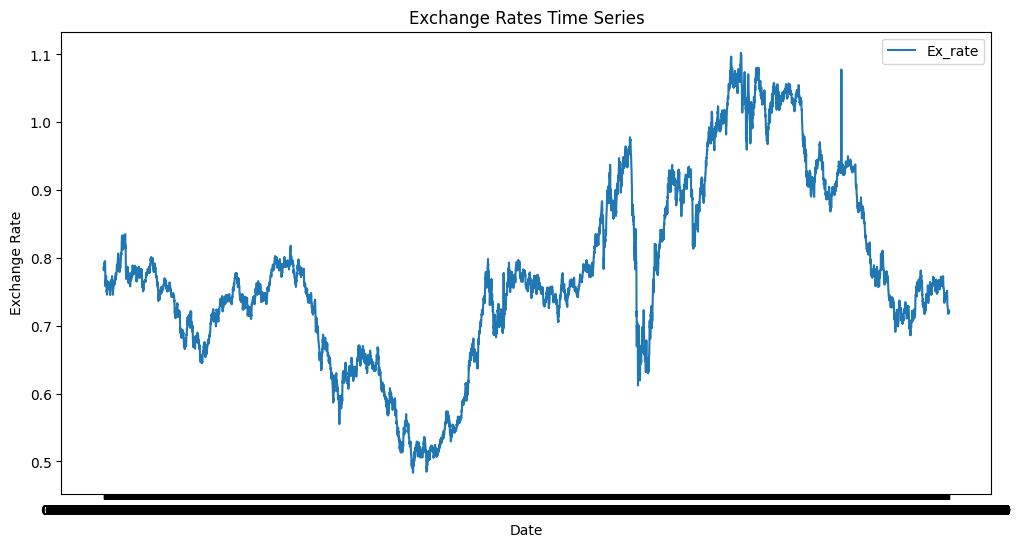

In [46]:
# Set the date column as the index
df.set_index('date', inplace=True)

# Plot the time series for each currency
plt.figure(figsize=(12, 6))
for column in df.columns:
    plt.plot(df.index, df[column], label=column)

plt.title('Exchange Rates Time Series')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()


In [47]:
df.isnull().sum()

Ex_rate    0
dtype: int64

# Part 2: Model Building - ARIMA
### 1.	Parameter Selection for ARIMA: Utilize ACF and PACF plots to estimate initial parameters (p, d, q) for the ARIMA model for one or more currency time series.
### 2.	Model Fitting: Fit the ARIMA model with the selected parameters to the preprocessed time series.
### 3.	Diagnostics: Analyze the residuals to ensure there are no patterns that might indicate model inadequacies.
### 4.	Forecasting: Perform out-of-sample forecasting and visualize the predicted values against the actual values.


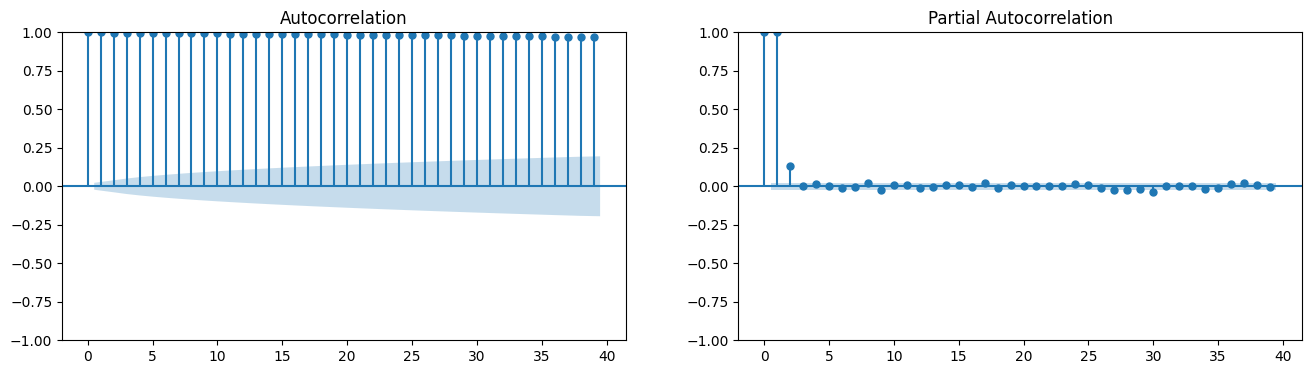

In [48]:
# Plot ACF and PACF for the selected currency time series
currency_series = df['Ex_rate'] 

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(currency_series, ax=axes[0])
plot_pacf(currency_series, ax=axes[1])
plt.show()


In [49]:
# Estimate initial parameters from ACF and PACF plots
p = 2  
d = 1  
q = 2  

# Fit the ARIMA model
model = ARIMA(currency_series, order=(p, d, q))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(2, 1, 2)   Log Likelihood               28055.068
Date:                Fri, 08 Nov 2024   AIC                         -56100.135
Time:                        20:02:31   BIC                         -56065.464
Sample:                             0   HQIC                        -56088.236
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1151      0.585     -0.197      0.844      -1.261       1.031
ar.L2          0.1132      0.088      1.293      0.196      -0.058       0.285
ma.L1         -0.0163      0.584     -0.028      0.9

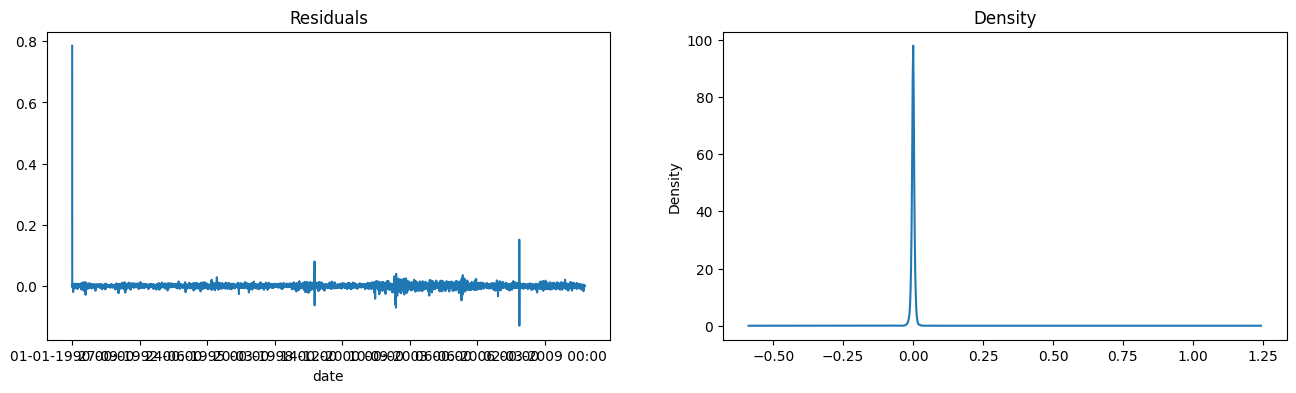

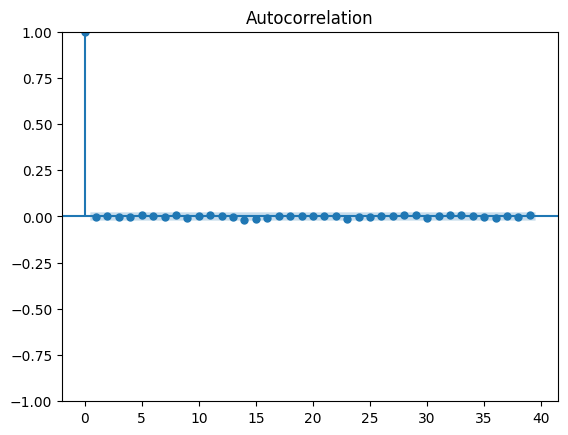

In [50]:
# Plot residuals
residuals = model_fit.resid

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
residuals.plot(title='Residuals', ax=axes[0])
residuals.plot(kind='kde', title='Density', ax=axes[1])
plt.show()

# Plot ACF of residuals
fig, ax = plt.subplots()
plot_acf(residuals, ax=ax)
plt.show()


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


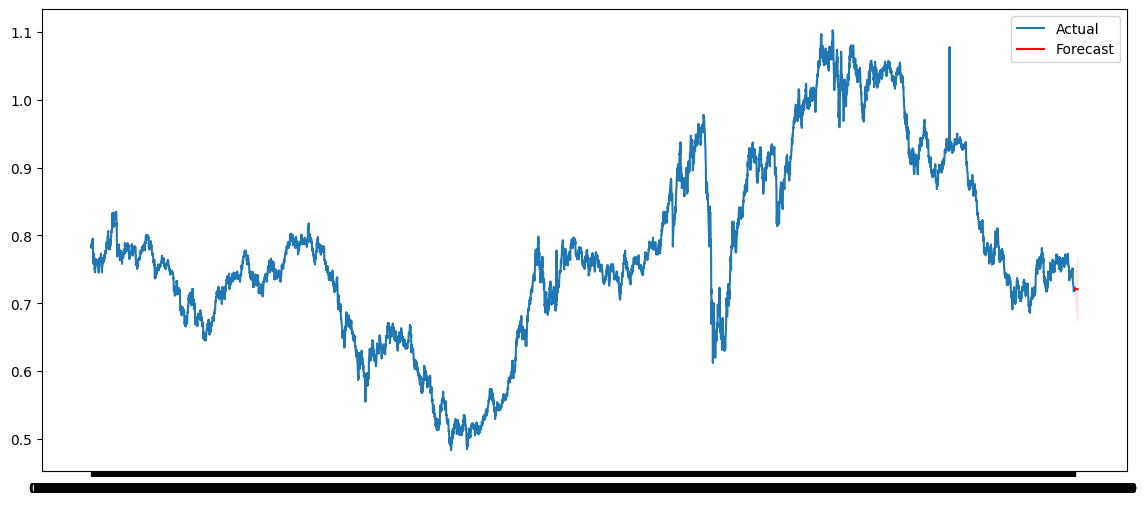

In [51]:
forecast_steps = 20  # Adjust as needed
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_index = forecast.predicted_mean.index

plt.figure(figsize=(14, 6))
plt.plot(currency_series, label='Actual')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_index,
                 forecast.conf_int().iloc[:, 0],
                 forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.show()


# Part 3: Model Building - Exponential Smoothing
### 1.	Model Selection: Depending on the time series characteristics, choose an appropriate Exponential Smoothing model (Simple, Holt’s Linear, or Holt-Winters).
### 2.	Parameter Optimization: Use techniques such as grid search or AIC to find the optimal parameters for the smoothing levels and components.
### 3.	Model Fitting and Forecasting: Fit the chosen Exponential Smoothing model and forecast future values. Compare these forecasts visually with the actual data.


In [52]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(currency_series)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")


ADF Statistic: -1.6649941807381528
p-value: 0.4492327353597901
The time series is not stationary.


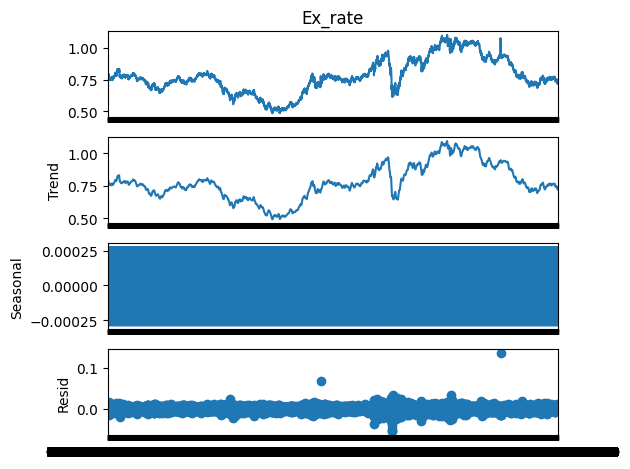

In [53]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(currency_series, model='additive', period=12)
decomposition.plot()
plt.show()


In [54]:
""" The most suitable model for this data would be:

 Holt’s Linear Trend Model beacause since the data shows a trend but lacks a clear seasonal component,
 Holt’s Linear model would be appropriate. It can capture the trend in the data without accounting for seasonality."""

' The most suitable model for this data would be:\n\n Holt’s Linear Trend Model beacause since the data shows a trend but lacks a clear seasonal component,\n Holt’s Linear model would be appropriate. It can capture the trend in the data without accounting for seasonality.'

In [55]:
train_data = currency_series[:-forecast_steps]  # Use most of the data for training
test_data = currency_series[-forecast_steps:]   # Last part for testing

In [56]:
# Fit Holt's Linear Trend Model
model = ExponentialSmoothing(train_data, trend='add', seasonal=None)
model_fit = model.fit(optimized=True)
print(model_fit.summary())

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7568
Model:             ExponentialSmoothing   SSE                              0.272
Optimized:                         True   AIC                         -77427.644
Trend:                         Additive   BIC                         -77399.917
Seasonal:                          None   AICC                        -77427.633
Seasonal Periods:                  None   Date:                 Fri, 08 Nov 2024
Box-Cox:                          False   Time:                         20:10:19
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.8698460                alpha                 True
smoothing_trend           1.5611e-

In [57]:
# Define actual values from the test set
actual_values = test_data

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


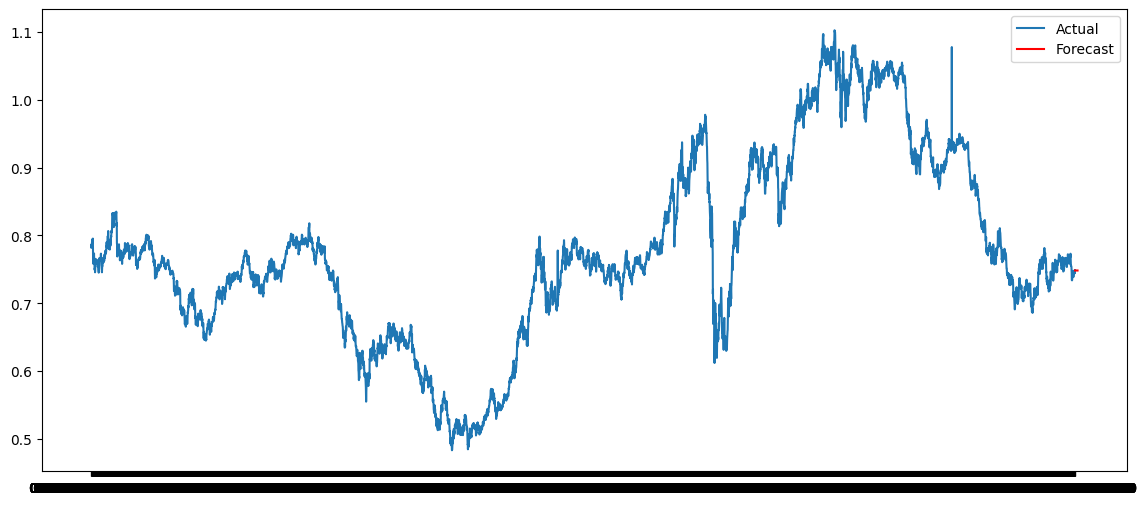

In [66]:
# Forecast
forecast_steps = 20  # Adjust as needed
forecast = model_fit.forecast(steps=forecast_steps)

# Visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
plt.plot(train_data, label='Actual')
plt.plot(forecast.index, forecast, label='Forecast', color='red')
plt.legend()
plt.show()

# Part 4: Evaluation and Comparison
### 1.	Compute Error Metrics: Use metrics such as MAE, RMSE, and MAPE to evaluate the forecasts from both models.
### 2.	Model Comparison: Discuss the performance, advantages, and limitations of each model based on the observed results and error metrics.
### 3.	Conclusion: Summarize the findings and provide insights on which model(s) yielded the best performance for forecasting exchange rates in this dataset.


In [77]:
arima_forecast = model_fit.forecast(steps=len(actual_values))

# Compute error metrics for ARIMA
mae_arima = mean_absolute_error(actual_values, arima_forecast)
rmse_arima = np.sqrt(mean_squared_error(actual_values, arima_forecast))
mape_arima = mean_absolute_percentage_error(actual_values, arima_forecast)


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [78]:
# Compute error metrics for Exponential Smoothing
mae_hw = mean_absolute_error(actual_values, forecast)
rmse_hw = np.sqrt(mean_squared_error(actual_values, forecast))
mape_hw = mean_absolute_percentage_error(actual_values, forecast)


In [79]:
print("ARIMA Model Error Metrics")
print(f"MAE: {mae_arima}")
print(f"RMSE: {rmse_arima}")
print(f"MAPE: {mape_arima}")

print("\nExponential Smoothing Model Error Metrics")
print(f"MAE: {mae_hw}")
print(f"RMSE: {rmse_hw}")
print(f"MAPE: {mape_hw}")


ARIMA Model Error Metrics
MAE: 0.022713122154905768
RMSE: 0.024139406932294237
MAPE: 0.03142634933710382

Exponential Smoothing Model Error Metrics
MAE: 0.022713122154905768
RMSE: 0.024139406932294237
MAPE: 0.03142634933710382


In [80]:
"""Model Comparison:
   Performance Evaluation:
      It looks like both the ARIMA and Exponential Smoothing models have produced the same error metrics. 
      This suggests that both models are performing equally well in terms of forecasting accuracy for your 
      time series data.

Advantages and Limitations:
   ARIMA:
     Advantages: Effective for non-seasonal data or when stationarity is a factor; can model complex patterns with tuning.
     Limitations: Needs careful parameter selection and differencing; less effective if strong seasonality is present.

   Holt’s Linear Trend Model:
     Advantages: Simple to use, effective for data with a linear trend; does not require complex tuning.
     Limitations: Cannot handle strong seasonal components or highly complex trends."""

'Model Comparison:\n   Performance Evaluation:\n      It looks like both the ARIMA and Exponential Smoothing models have produced the same error metrics. \n      This suggests that both models are performing equally well in terms of forecasting accuracy for your \n      time series data.\n\nAdvantages and Limitations:\n   ARIMA:\n     Advantages: Effective for non-seasonal data or when stationarity is a factor; can model complex patterns with tuning.\n     Limitations: Needs careful parameter selection and differencing; less effective if strong seasonality is present.\n\n   Holt’s Linear Trend Model:\n     Advantages: Simple to use, effective for data with a linear trend; does not require complex tuning.\n     Limitations: Cannot handle strong seasonal components or highly complex trends.'

In [81]:
""" Equal Performance: The identical error metrics indicate that, at least for the specific dataset and forecast horizon we used, 
                       both ARIMA and Exponential Smoothing are performing equally well."""

' Equal Performance: The identical error metrics indicate that, at least for the specific dataset and forecast horizon we used, \n                       both ARIMA and Exponential Smoothing are performing equally well.'